In [16]:
#necessary libraries
import librosa
import os
import pandas as pd
import glob

In [10]:
#import tracks csv file for track_id and genre_top
tracks=pd.read_csv("./fma_metadata/tracks.csv", low_memory=False)

In [11]:
#all track ids start from index 2
id=tracks['Unnamed: 0'][2:]
id.head()

2     2
3     3
4     5
5    10
6    20
Name: Unnamed: 0, dtype: object

In [12]:
#labels for tracks start from index 2
genre=tracks['track.7'][2:]
genre.head()

2    Hip-Hop
3    Hip-Hop
4    Hip-Hop
5        Pop
6        NaN
Name: track.7, dtype: object

In [13]:
#change the track_id name to match fma_small filenames
count=2
for i in id:
    if len(i)==1:
        id[count]='00000'+i+'.mp3'
        count+=1
    elif len(i)==2:
        id[count]='0000'+i+'.mp3'
        count+=1
    elif len(i)==3:
        id[count]='000'+i+'.mp3'
        count+=1
    elif len(i)==4:
        id[count]='00'+i+'.mp3'
        count+=1
    elif len(i)==5:
        id[count]='0'+i+'.mp3'
        count+=1
#check if it worked
id.head()

2    000002.mp3
3    000003.mp3
4    000005.mp3
5    000010.mp3
6    000020.mp3
Name: Unnamed: 0, dtype: object

In [46]:
#load audio files and extract features
x=[] #will hold feature data
y=[] #will hold label data
path=os.path.abspath(os.path.join("./fma_medium/"))
for subfolder in os.listdir(path):
    for filename in os.listdir(os.path.join(path,subfolder)):
        try:
            song, samp_rate=librosa.load(os.path.join(path,subfolder,filename), res_type='kaiser_fast')
            #extract mfcc feature from data
            #mfcc = mel-frequency cepstral coefficients
            #mfcc mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker
            #dependent characteristics by excluding the fundamental frequency and their harmonics
            feature=np.mean(librosa.feature.mfcc(y=song, sr=samp_rate, n_mfcc=40).T, axis=0)
            x.append(feature)
            label=genre.loc[id == filename].values.tolist()
            if 'Hip-Hop' in label:
                label=0
                y.append(label)
            elif 'Pop' in label:
                label=1
                y.append(label)
            elif 'Folk' in label:
                label=2
                y.append(label)
            elif 'Rock' in label:
                label=3
                y.append(label)    
            elif 'Experimental' in label:
                label=4
                y.append(label)    
            elif 'International' in label:
                label=5
                y.append(label)    
            elif 'Instrumental' in label:
                label=6
                y.append(label)    
            elif 'Electronic' in label:
                label=7
                y.append(label)    
            else:
                y.append(8)
        except Exception as e:
            print("Error encountered for file: ", filename)

Error encountered for file:  .ipynb_checkpoints
Error encountered for file:  133297.mp3
Error encountered for file:  108925.mp3
Error encountered for file:  099134.mp3


In [ ]:
#save x and y before splitting into train/test and before putting into DataFrame
np.save('x_all.npy', x)
np.save('y_all.npy', y)

In [ ]:
#load the x and y numpy arrays
x=np.load('x_all.npy')
y=np.load('y_all.npy')

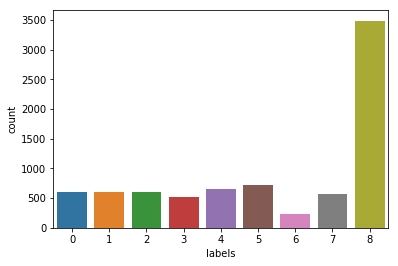

In [47]:
df=pd.DataFrame()
df['songs']=x
df['labels']=y

lab=df['labels']
dist=lab.value_counts()

#view the distribution of genres
import seaborn as sns
sns.countplot(lab)

In [48]:
#convert features to numpy array
import numpy as np
x=np.array(x)

#describe new numpy array
dict_characters={0: 'Hip-Hop',1: 'Pop',2: 'Folk',3: 'Rock',4: 'Experimental',5: 'International',6: 'Instrumental',7: 'Electronic',8: 'Other'}
#NOT SURE WHY SOME FILES READ IN WITH EMPTY GENRE...ONLY SUPPOSED TO HAVE 8 GENRES/ALL BALANCED
#BECAUSE OF THIS ISSUE I CODED EMPTY GENRES TO 8 WHICH WE WILL DROP LATER

In [49]:
#create training and testing data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

#check the dimensions
print(x_train.shape)
print(x_test.shape)

(5597, 40)
(2400, 40)


In [50]:
#dummy code labels using one hot encoding
from keras.utils.np_utils import to_categorical

y_trainHot=to_categorical(y_train,num_classes=9)
y_testHot=to_categorical(y_test,num_classes=9)

/home/cc/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [51]:
#save variables using pickle
np.save('x_train.npy', x_train)
np.save('x_test.npy', x_test)
np.save('y_train.npy', y_train) #not needed after this
np.save('y_test.npy', y_test) #not needed after this
np.save('y_trainHot.npy', y_trainHot)
np.save('y_testHot.npy', y_testHot)

In [52]:
#****START HERE FOR RUNNING ON YOUR OWN MACHINES****#
#load the variables using pickle
np.load('x_train.npy')
np.load('x_test.npy')
np.load('y_trainHot.npy')
np.load('y_testHot.npy')

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [53]:
# Helper Functions, Learning Curves, and Confusion Matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pylab as plt

#save all previous epochs for use in plotting Keras Learning Curve
#this is used in function below called plotKerasLearningCurve
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

#Keras Learning Curve function
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    
#Confuson Matrix function
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [54]:
#deep learning libraries
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.layers import Convolution2D,MaxPooling2D
from keras.optimizers import Adam
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [55]:
#****EDIT THIS FOR TRYING DIFFERENT MODELS****#

#deep learning model
#a = x_train
#b = y_trainHot
#c = x_test
#d = y_testHot
#e = number of epochs
def runCNNmodel(a,b,c,d,e):
    batch=32
    num_labels=9
    filter_size=2 #what is filter size?
    #intialize model
    model=Sequential()
    
    #visible layers
    model.add(Dense(256,input_shape=(40,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    #hidden layers
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    #8 output nodes
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))
    
    #compile the model
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

    #train the model
    model.fit(a,b,batch_size=batch,epochs=e,validation_data=(c,d),callbacks=[MetricsCheckpoint('logs')])
    
    #compute predictions for confusion matrix
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1),target_names=list(dict_characters.values())), sep='')
    Y_pred_classes = np.argmax(Y_pred,axis = 1)
    Y_true = np.argmax(d,axis = 1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    
    #plot confusion matrix
    plot_confusion_matrix(cm=confusion_mtx,classes=list(dict_characters.values()))

Train on 5597 samples, validate on 2400 samples
Epoch 1/10
5597/5597 [==============================] - 1s 176us/step - loss: 8.2982 - acc: 0.3547 - val_loss: 3.2483 - val_acc: 0.3883
Epoch 2/10
5597/5597 [==============================] - 1s 135us/step - loss: 2.9094 - acc: 0.3057 - val_loss: 1.9975 - val_acc: 0.4350
Epoch 3/10
5597/5597 [==============================] - 1s 138us/step - loss: 2.0014 - acc: 0.3950 - val_loss: 1.8573 - val_acc: 0.4350
Epoch 4/10
5597/5597 [==============================] - 1s 143us/step - loss: 1.8745 - acc: 0.4240 - val_loss: 1.7818 - val_acc: 0.4383
Epoch 5/10
5597/5597 [==============================] - 1s 137us/step - loss: 1.7990 - acc: 0.4349 - val_loss: 1.7351 - val_acc: 0.4425
Epoch 6/10
5597/5597 [==============================] - 1s 140us/step - loss: 1.7800 - acc: 0.4352 - val_loss: 1.6992 - val_acc: 0.4421
Epoch 7/10
5597/5597 [==============================] - 1s 134us/step - loss: 1.7542 - acc: 0.4359 - val_loss: 1.6893 - val_acc: 0.4421


/home/cc/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


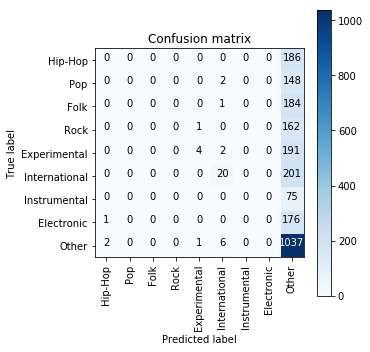

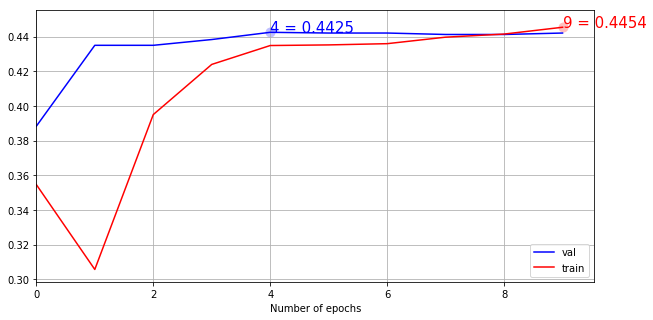

In [57]:
#run the model
runCNNmodel(x_train,y_trainHot,x_test,y_testHot,10)
#plot learning curves across epochs
plotKerasLearningCurve()